# Required Packages and Utilities

In [1]:
# Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import gzip

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

# Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, RocCurveDisplay

%matplotlib inline

import warnings
warnings.simplefilter("ignore")

# Display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Data Extraction

In [2]:
iot_data = pd.read_csv('iot_dataset.csv')

In [3]:
# Datset Summary
iot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451498 entries, 0 to 451497
Data columns (total 47 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    451498 non-null  float64
 1   Header_Length    451498 non-null  float64
 2   Protocol Type    451498 non-null  float64
 3   Duration         451498 non-null  float64
 4   Rate             451498 non-null  float64
 5   Srate            451498 non-null  float64
 6   Drate            451498 non-null  float64
 7   fin_flag_number  451498 non-null  float64
 8   syn_flag_number  451498 non-null  float64
 9   rst_flag_number  451498 non-null  float64
 10  psh_flag_number  451498 non-null  float64
 11  ack_flag_number  451498 non-null  float64
 12  ece_flag_number  451498 non-null  float64
 13  cwr_flag_number  451498 non-null  float64
 14  ack_count        451498 non-null  float64
 15  syn_count        451498 non-null  float64
 16  fin_count        451498 non-null  floa

In [4]:
# Show dataset columns
iot_data.columns

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label'],
      dtype='object')

# Data Cleaning

In [5]:
# Check for null values in the entire dataset
null_values = iot_data.isnull().sum()

if null_values.any():
    print("DataFrame contains null values.")
    # Display columns with null values and their counts
    print(null_values[null_values > 0])
else:
    print("DataFrame does not contain null values.")

DataFrame does not contain null values.


In [6]:
# Extract only numeric columns
numeric_columns = iot_data.select_dtypes(include=np.number).columns

# Check for infinity values in the numeric columns
if np.any(np.isinf(iot_data[numeric_columns])):
    print("Dataset contains infinity values.")

    # Identify columns with infinity values
    for col in numeric_columns:
        inf_count = np.sum(np.isinf(iot_data[col]))
        if inf_count:
            print(col, inf_count)

else:
    print("Dataset does not contain infinity values.")

Dataset does not contain infinity values.


In [7]:
# Get single-valued columns
single_valued_columns = [col for col in iot_data.columns if iot_data[col].nunique() == 1]

# Display single-valued columns
print('There are', len(single_valued_columns), 'single-valued columns:')
print(single_valued_columns)

# Remove single-valued columns
iot_data.drop(labels=single_valued_columns, axis=1, inplace=True)

There are 6 single-valued columns:
['ece_flag_number', 'cwr_flag_number', 'Telnet', 'SMTP', 'IRC', 'DHCP']


In [8]:
# All Labels
print("Number of Categories: ", iot_data['label'].nunique())
print(iot_data['label'].unique())

# Map labels to collapse caategories
label_mapping_dict = {
    'Backdoor_Malware': 'Web-Based',
    'BenignTraffic': 'Benign',
    'BrowserHijacking': 'Web-Based',
    'CommandInjection': 'Web-Based',
    'DDoS-ACK_Fragmentation': 'DDoS',
    'DDoS-HTTP_Flood': 'DDoS',
    'DDoS-ICMP_Flood': 'DDoS',
    'DDoS-ICMP_Fragmentation': 'DDoS',
    'DDoS-PSHACK_Flood': 'DDoS',
    'DDoS-RSTFINFlood': 'DDoS',
    'DDoS-SYN_Flood': 'DDoS',
    'DDoS-SlowLoris': 'DDoS',
    'DDoS-SynonymousIP_Flood': 'DDoS',
    'DDoS-TCP_Flood': 'DDoS',
    'DDoS-UDP_Flood': 'DDoS',
    'DDoS-UDP_Fragmentation': 'DDoS',
    'DNS_Spoofing': 'Spoofing',
    'DictionaryBruteForce': 'BruteForce',
    'DoS-HTTP_Flood': 'DoS',
    'DoS-SYN_Flood': 'DoS',
    'DoS-TCP_Flood': 'DoS',
    'DoS-UDP_Flood': 'DoS',
    'MITM-ArpSpoofing': 'Spoofing',
    'Mirai-greeth_flood': 'Mirai',
    'Mirai-greip_flood': 'Mirai',
    'Mirai-udpplain': 'Mirai',
    'Recon-HostDiscovery': 'Recon',
    'Recon-OSScan': 'Recon',
    'Recon-PingSweep': 'Recon',
    'Recon-PortScan': 'Recon',
    'SqlInjection': 'Web-Based',
    'Uploading_Attack': 'Web-Based',
    'VulnerabilityScan': 'Recon',
    'XSS': 'Web-Based'
}

iot_data['label'] = iot_data['label'].replace(label_mapping_dict)

# New Labels
print('\n')

print("Number of Classes after mapping: ", iot_data['label'].nunique())
print(iot_data['label'].unique())
print(iot_data['label'].value_counts())

Number of Categories:  34
['DDoS-ICMP_Flood' 'DDoS-RSTFINFlood' 'DDoS-SYN_Flood'
 'DDoS-SynonymousIP_Flood' 'BenignTraffic' 'DDoS-UDP_Flood'
 'DDoS-PSHACK_Flood' 'DoS-UDP_Flood' 'Mirai-greeth_flood'
 'DDoS-UDP_Fragmentation' 'DDoS-TCP_Flood' 'DoS-TCP_Flood'
 'Mirai-udpplain' 'Recon-HostDiscovery' 'DDoS-ICMP_Fragmentation'
 'Mirai-greip_flood' 'DoS-SYN_Flood' 'DoS-HTTP_Flood' 'MITM-ArpSpoofing'
 'Recon-PortScan' 'DDoS-ACK_Fragmentation' 'DDoS-HTTP_Flood'
 'DNS_Spoofing' 'DictionaryBruteForce' 'Recon-OSScan' 'BrowserHijacking'
 'CommandInjection' 'VulnerabilityScan' 'SqlInjection' 'DDoS-SlowLoris'
 'Backdoor_Malware' 'XSS' 'Uploading_Attack' 'Recon-PingSweep']


Number of Classes after mapping:  8
['DDoS' 'Benign' 'DoS' 'Mirai' 'Recon' 'Spoofing' 'BruteForce' 'Web-Based']
DDoS          328601
DoS            78047
Mirai          25726
Benign         10507
Spoofing        4731
Recon           3515
Web-Based        238
BruteForce       133
Name: label, dtype: int64


In [9]:
# To ensure datatype uniformity, change columns' datatype to integer

iot_data['Protocol Type'] = iot_data['Protocol Type'].astype(int)
iot_data['psh_flag_number'] = iot_data['psh_flag_number'].astype(int)

iot_data['ack_count'] = iot_data['ack_count'].astype(int)
iot_data['syn_count'] = iot_data['syn_count'].astype(int)
iot_data['fin_count'] = iot_data['fin_count'].astype(int)
iot_data['rst_count'] = iot_data['rst_count'].astype(int)
iot_data['urg_count'] = iot_data['urg_count'].astype(int)

## Feature Selection

In [10]:
### Removal of Irrelevant/Redundant columns

cols_to_remove = ['Duration', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
                  'rst_flag_number', 'ack_flag_number', 'HTTP', 'HTTPS', 'DNS', 'SSH', 'TCP',
                  'UDP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std',
                  'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']

In [11]:
# Drop columns
iot_data = iot_data.drop(labels=cols_to_remove, axis=1)
print(iot_data.columns)

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Rate',
       'psh_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count',
       'rst_count', 'Tot size', 'IAT', 'label'],
      dtype='object')


# Exploratory Data Analysis

In [12]:
# Get first five rows of DataFrame
iot_data.head()

,flow_duration,Header_Length,Protocol Type,Rate,psh_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,Tot size,IAT,label
0,0.000000,0.0,1,204.980158,0,0,0,0,0,0,42.0,8.315011e+07,DDoS
1,0.000000,54.0,6,0.000000,0,1,0,1,0,0,54.0,8.334862e+07,DDoS
2,0.000000,54.0,6,0.000000,0,0,1,0,0,0,54.0,8.308927e+07,DDoS
3,3.394034,210.6,6,1.144677,0,0,3,0,0,0,54.0,8.336215e+07,DDoS
4,0.000000,54.0,6,0.992022,0,1,0,1,0,0,54.0,8.334381e+07,DDoS


In [13]:
# Get number of rows and columns
iot_data.shape

(451498, 13)

In [14]:
# Show the names and datatypes of columns
iot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451498 entries, 0 to 451497
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    451498 non-null  float64
 1   Header_Length    451498 non-null  float64
 2   Protocol Type    451498 non-null  int32  
 3   Rate             451498 non-null  float64
 4   psh_flag_number  451498 non-null  int32  
 5   ack_count        451498 non-null  int32  
 6   syn_count        451498 non-null  int32  
 7   fin_count        451498 non-null  int32  
 8   urg_count        451498 non-null  int32  
 9   rst_count        451498 non-null  int32  
 10  Tot size         451498 non-null  float64
 11  IAT              451498 non-null  float64
 12  label            451498 non-null  object 
dtypes: float64(5), int32(7), object(1)
memory usage: 32.7+ MB


In [15]:
# Shows the percentiles of numerical data (datatype - float & int)
iot_data.describe()

,flow_duration,Header_Length,Protocol Type,Rate,psh_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,Tot size,IAT
count,451498.000000,4.514980e+05,451498.000000,4.514980e+05,451498.000000,451498.000000,451498.000000,451498.000000,451498.000000,451498.000000,451498.000000,4.514980e+05
mean,5.715186,7.704312e+04,8.944153,9.467058e+03,0.087416,0.071876,0.258455,0.074410,6.239419,38.113927,124.983505,8.321214e+07
std,260.774301,4.635026e+05,8.914034,1.033561e+05,0.282444,0.260699,0.569804,0.322821,73.156074,324.790731,241.765667,1.704557e+07
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000,0.000000e+00
25%,0.000000,5.400000e+01,6.000000,2.091460e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,8.307157e+07
50%,0.000000,5.400000e+01,6.000000,1.571264e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,54.000000,8.312453e+07
75%,0.105739,2.877100e+02,14.000000,1.184370e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,54.060000,8.334400e+07
max,64016.004351,9.785469e+06,47.000000,7.340032e+06,1.000000,3.000000,6.000000,75.000000,3157.000000,9506.000000,8754.000000,1.676394e+08


In [16]:
# Show the number of unique values for each column
for col in iot_data.columns:
        print(col, iot_data[col].nunique())

flow_duration 205845
Header_Length 96461
Protocol Type 48
Rate 404160
psh_flag_number 2
ack_count 4
syn_count 7
fin_count 14
urg_count 1268
rst_count 3814
Tot size 21756
IAT 451055
label 8


## Visualizations

There are 48 unique protocol types in the dataset.


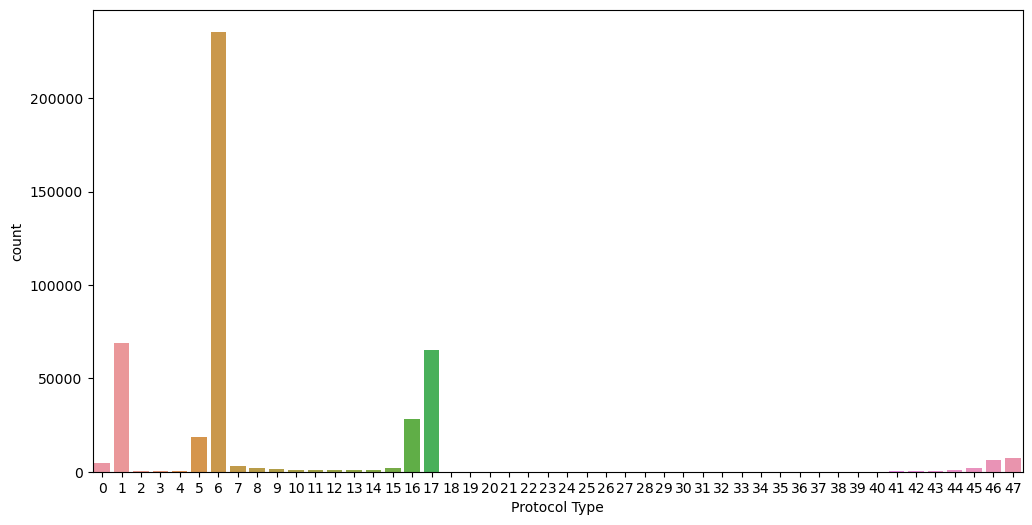

In [17]:
# Show the number of unique protocol types
print(f"There are {iot_data['Protocol Type'].nunique()} unique protocol types in the dataset.")

# Display the unique protocol types and their counts
plt.figure(figsize=(12,6))
sns.countplot(data=iot_data, x='Protocol Type')

plt.show()

label
Web-Based       784.131996
Recon          1560.167025
BruteForce     1827.659889
Benign         2018.181784
Spoofing       2285.658082
Mirai          8014.071426
DDoS           9499.006292
DoS           11645.196707
Name: Rate, dtype: float64


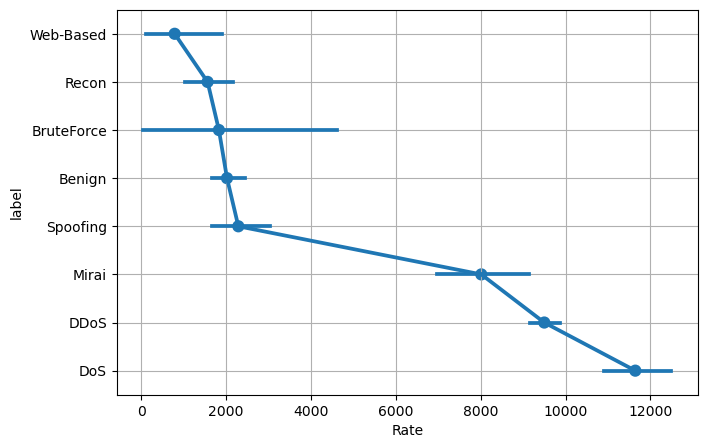

In [18]:
# Display mean_flow_rate per label.
# Lines show 95% confidence intervals for the mean
label_flw_pkt_ps = iot_data.groupby('label')['Rate'].mean().sort_values()
print(label_flw_pkt_ps)

plt.figure(figsize=(7.5,5))
sns.pointplot(data=iot_data, x='Rate', y='label', order=label_flw_pkt_ps.index)

plt.grid()
plt.show()

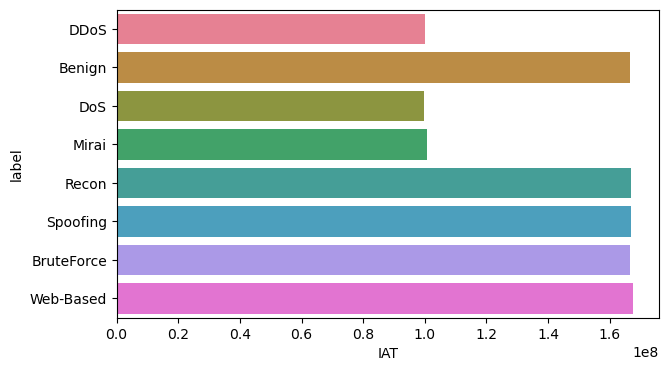

In [19]:
# Show the maximum IAT for each label
plt.figure(figsize=(7,4))
sns.barplot(data=iot_data, x='IAT', y='label', estimator='max', palette='husl')
plt.show()

label       psh_flag_number
Benign      0                   10311
            1                     196
BruteForce  0                     122
            1                      11
DDoS        0                  289858
            1                   38743
DoS         0                   78025
            1                      22
Mirai       0                   25724
            1                       2
Recon       0                    3441
            1                      74
Spoofing    0                    4323
            1                     408
Web-Based   0                     226
            1                      12
Name: psh_flag_number, dtype: int64


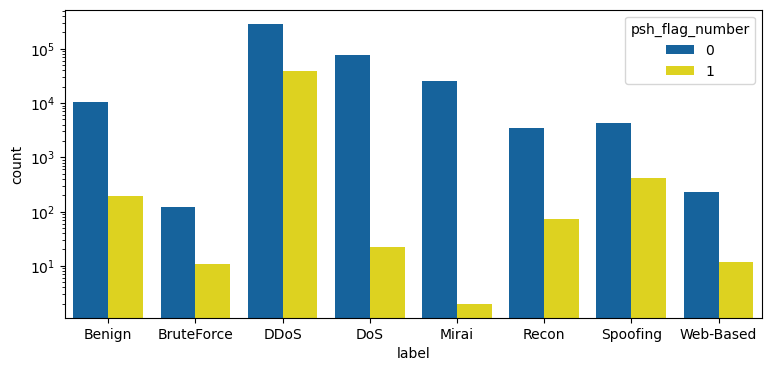

In [20]:
# Count the occurrences of each unique value in 'psh_flag_number' for each label
print(iot_data.groupby('label')['psh_flag_number'].value_counts())
ordered_labels = sorted(list(iot_data['label'].unique()))

plt.figure(figsize=(9,4))
sns.countplot(data=iot_data, x='label', order=ordered_labels, hue='psh_flag_number', palette=['#0066B2', '#FDEE00'])
plt.yscale('log', base=10)

# Transformation of Labels

In [21]:
### BINARY CLASSIFICATION

# Mapping of Benigh to 0, and attack types to 1
iot_data['Target_Binary'] = iot_data['label'].map(lambda a: 0 if a == 'Benign' else 1)

print(iot_data['Target_Binary'].value_counts())

1    440991
0     10507
Name: Target_Binary, dtype: int64


Attacks    440991
Benign      10507
Name: Target_Binary, dtype: int64


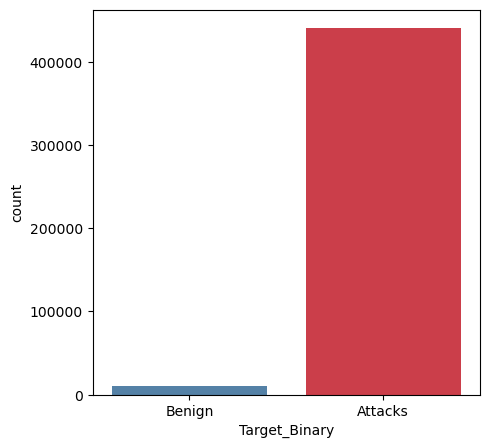

In [22]:
# Show Binary Classification Labels
bin_labels_count = iot_data['Target_Binary'].value_counts()
bin_labels_count.index = ['Attacks', 'Benign']
print(bin_labels_count)

plt.figure(figsize=(5,5))
sns.countplot(data=iot_data, x='Target_Binary', palette=['#4682b4', '#e32636'])
plt.xticks([0, 1], ['Benign', 'Attacks'])
plt.show()

In [23]:
### MULTI-CLASS CLASSIFICATION

# Assign number to labels
all_labels = sorted(list(iot_data['label'].unique()))
index_and_labels = list(enumerate(all_labels))

print(index_and_labels, '\n')

# Mapping of dataset labels to unique numbers
def map_label_to_num(current_label):
    for index, label in index_and_labels:
        if current_label == label:
            return index
        
iot_data['Target_Multi'] = iot_data['label'].apply(map_label_to_num)

print(iot_data['Target_Multi'].value_counts())

[(0, 'Benign'), (1, 'BruteForce'), (2, 'DDoS'), (3, 'DoS'), (4, 'Mirai'), (5, 'Recon'), (6, 'Spoofing'), (7, 'Web-Based')] 

2    328601
3     78047
4     25726
0     10507
6      4731
5      3515
7       238
1       133
Name: Target_Multi, dtype: int64


DDoS          328601
DoS            78047
Mirai          25726
Benign         10507
Spoofing        4731
Recon           3515
Web-Based        238
BruteForce       133
Name: label, dtype: int64


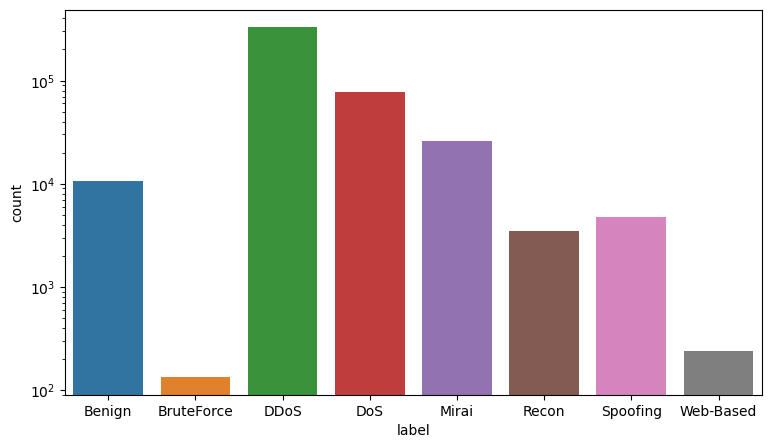

In [24]:
# Show Labels
print(iot_data['label'].value_counts())

plt.figure(figsize=(9, 5))
sns.countplot(data=iot_data, x='label', order=ordered_labels)

# Set y-axis scale to logarithmic and specify the base as 10
plt.yscale('log', base=10)

plt.show()

### Separation of Features and Labels

In [25]:
# Show the names and datatypes of final set of columns
iot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451498 entries, 0 to 451497
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    451498 non-null  float64
 1   Header_Length    451498 non-null  float64
 2   Protocol Type    451498 non-null  int32  
 3   Rate             451498 non-null  float64
 4   psh_flag_number  451498 non-null  int32  
 5   ack_count        451498 non-null  int32  
 6   syn_count        451498 non-null  int32  
 7   fin_count        451498 non-null  int32  
 8   urg_count        451498 non-null  int32  
 9   rst_count        451498 non-null  int32  
 10  Tot size         451498 non-null  float64
 11  IAT              451498 non-null  float64
 12  label            451498 non-null  object 
 13  Target_Binary    451498 non-null  int64  
 14  Target_Multi     451498 non-null  int64  
dtypes: float64(5), int32(7), int64(2), object(1)
memory usage: 39.6+ MB


In [26]:
# Drop target columns to get only features
numeric_features = list(iot_data.columns.drop(['label', 'Target_Binary', 'Target_Multi']))

# Features
X = iot_data[numeric_features].values

# Target variables
bin_y = iot_data['Target_Binary'].values
multi_y = iot_data['Target_Multi'].values

# Model Fitting and Evaluation

In [27]:
# Set seed for reproducibility
SEED = 21

# Instantiate models
models = [RandomForestClassifier(random_state=SEED),
          KNeighborsClassifier(),
          LogisticRegression(random_state=SEED, max_iter=300)]

## Binary Classification

In [28]:
# Split data into 70% training set and 30% test set
# X: features; y: target
bin_X_train, bin_X_test, bin_y_train, bin_y_test = train_test_split(X, bin_y, test_size=0.3, random_state=SEED)

print('Shape of training set: ', bin_X_train.shape)
print('Shape of test set: ', bin_X_test.shape)

Shape of training set:  (316048, 12)
Shape of test set:  (135450, 12)



RandomForestClassifier

Accuracy: 0.997
Precision: 0.999
F1_Score: 0.999
TPR: 0.998
TNR: 0.943
AUC_ROC: 0.971 


              precision    recall  f1-score   support

      Benign       0.93      0.94      0.94      3179
     Attacks       1.00      1.00      1.00    132271

    accuracy                           1.00    135450
   macro avg       0.97      0.97      0.97    135450
weighted avg       1.00      1.00      1.00    135450

[[  2999    180]
 [   210 132061]]


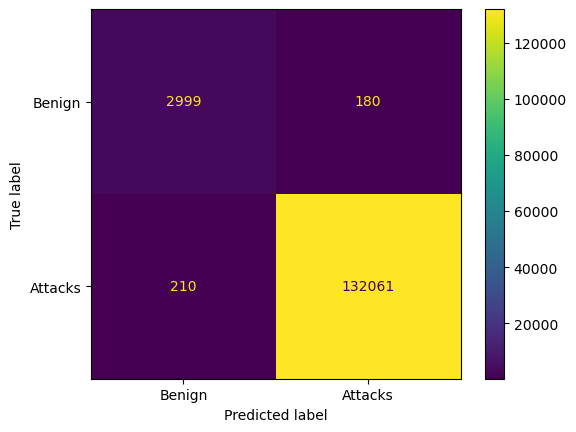

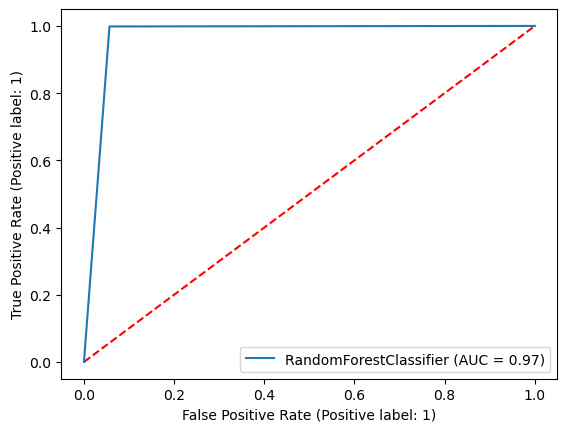


KNeighborsClassifier

Accuracy: 0.992
Precision: 0.997
F1_Score: 0.996
TPR: 0.995
TNR: 0.874
AUC_ROC: 0.935 


              precision    recall  f1-score   support

      Benign       0.81      0.87      0.84      3179
     Attacks       1.00      1.00      1.00    132271

    accuracy                           0.99    135450
   macro avg       0.90      0.93      0.92    135450
weighted avg       0.99      0.99      0.99    135450

[[  2779    400]
 [   641 131630]]


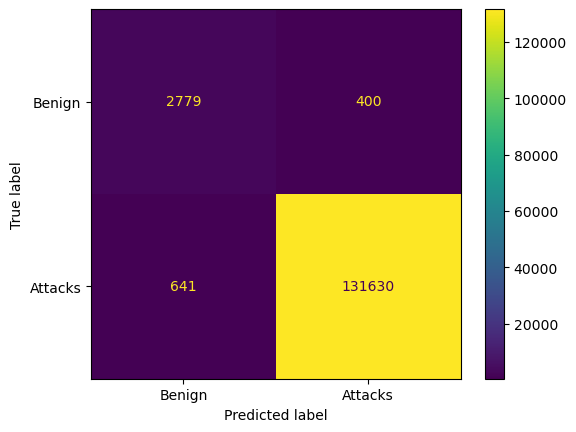

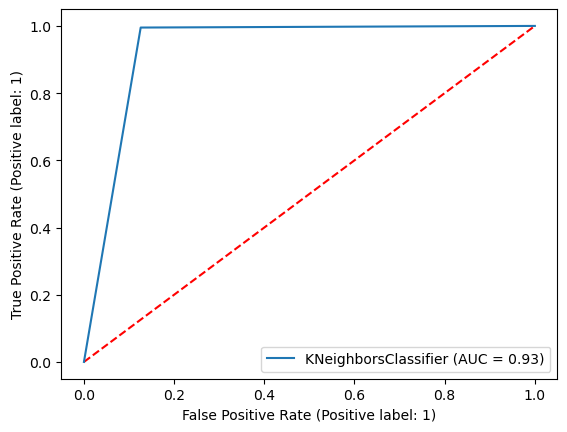


LogisticRegression

Accuracy: 0.979
Precision: 0.988
F1_Score: 0.99
TPR: 0.991
TNR: 0.494
AUC_ROC: 0.743 


              precision    recall  f1-score   support

      Benign       0.57      0.49      0.53      3179
     Attacks       0.99      0.99      0.99    132271

    accuracy                           0.98    135450
   macro avg       0.78      0.74      0.76    135450
weighted avg       0.98      0.98      0.98    135450

[[  1572   1607]
 [  1171 131100]]


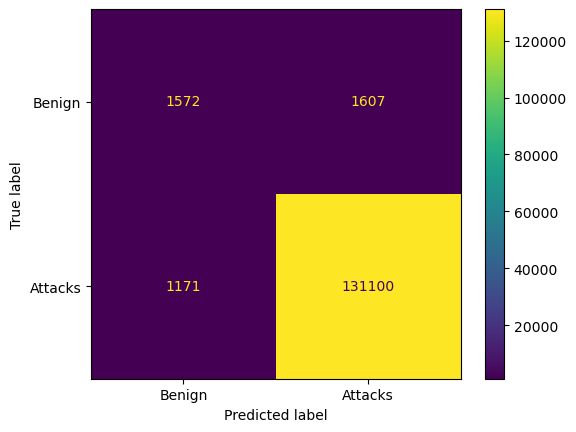

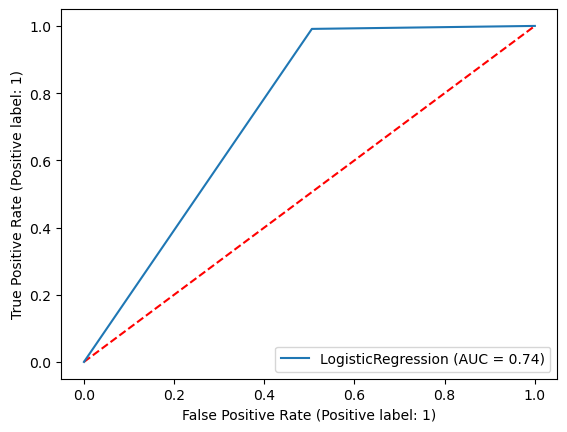

In [29]:
# Lists for evaluation metrics
bin_model = []
bin_accuracy = []
bin_precision = []
bin_tpr = []          
bin_f1 =[]
bin_tnr = []     
bin_auc_roc =[]

for model in models:
    model_name = model.__class__.__name__

    model.fit(bin_X_train, bin_y_train)               # train the ML algorithm on the training data
    model_pred = model.predict(bin_X_test)            # predict labels

    cm = confusion_matrix(bin_y_test, model_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Attacks'])

    # Mapping of scorer name to scorer function
    # Round up values to 3 decimal places
    accuracy = round(metrics.accuracy_score(bin_y_test, model_pred), 3)
    precision = round(metrics.precision_score(bin_y_test, model_pred), 3)
    f1_score = round(metrics.f1_score(bin_y_test, model_pred), 3)
    tpr = round(metrics.recall_score(bin_y_test, model_pred), 3)
    tnr = round(cm[0,0]/(cm[0,0]+cm[0,1]), 3)
    auc_roc = round(roc_auc_score(bin_y_test, model_pred), 3)

    # Append results to corresponding lists
    bin_model.append(model_name)
    bin_accuracy.append(accuracy)
    bin_precision.append(precision)
    bin_f1.append(f1_score)
    bin_tpr.append(tpr)
    bin_tnr.append(tnr)
    bin_auc_roc.append(auc_roc)

    print(f"\n{model_name}")

    print('\nAccuracy: {}'.format(accuracy))
    print('Precision: {}'.format(precision))
    print('F1_Score: {}'.format(f1_score))
    print('TPR: {}'.format(tpr))
    print('TNR: {}'.format(tnr))
    print('AUC_ROC: {} \n\n'.format(auc_roc))

    print(classification_report(bin_y_test, model_pred, target_names=['Benign', 'Attacks']))
    print(cm)
    cm_display.plot()
    plt.show()

    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], 'r--')
    RocCurveDisplay.from_predictions(bin_y_test, model_pred, name=str(model_name), ax=ax)
    plt.show()

    print("=" * 120)

In [30]:
# Convert lists to a single DataFrame
bin_dict_of_lists = {
    "Bin_Model": bin_model,
    "Bin_Accuracy": bin_accuracy,
    "Bin_Precision": bin_precision,
    "Bin_F1_Score": bin_f1,
    "Bin_TPR": bin_tpr,
    "Bin_TNR": bin_tnr,
    "Bin_AUC_ROC": bin_auc_roc
}

bin_all_results = pd.DataFrame(bin_dict_of_lists)
bin_all_results

,Bin_Model,Bin_Accuracy,Bin_Precision,Bin_F1_Score,Bin_TPR,Bin_TNR,Bin_AUC_ROC
0,RandomForestClassifier,0.997,0.999,0.999,0.998,0.943,0.971
1,KNeighborsClassifier,0.992,0.997,0.996,0.995,0.874,0.935
2,LogisticRegression,0.979,0.988,0.990,0.991,0.494,0.743


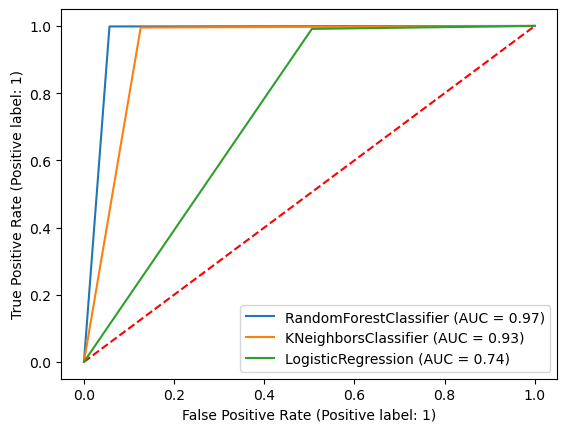

In [31]:
# Show all ROC curves in one chart

ax = plt.gca()
ax.plot([0, 1], [0, 1], 'r--')

for model in models:
    model_name = model.__class__.__name__
    model.fit(bin_X_train, bin_y_train)
    model_pred = model.predict(bin_X_test)
    RocCurveDisplay.from_predictions(bin_y_test, model_pred, name=str(model_name), ax=ax)

plt.show()

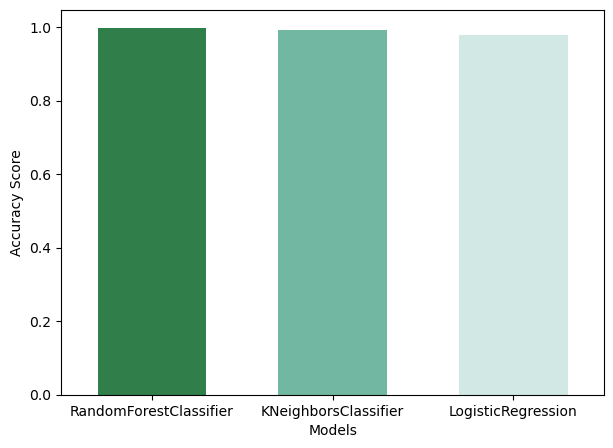

In [32]:
# Display accuracies
plt.figure(figsize=(7,5))
sns.barplot(data=bin_all_results, x='Bin_Model', y='Bin_Accuracy', palette='BuGn_r', width=0.6)

plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

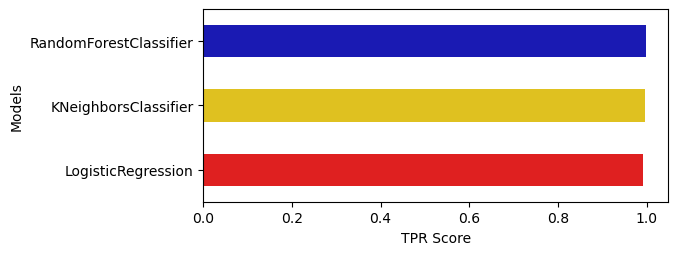

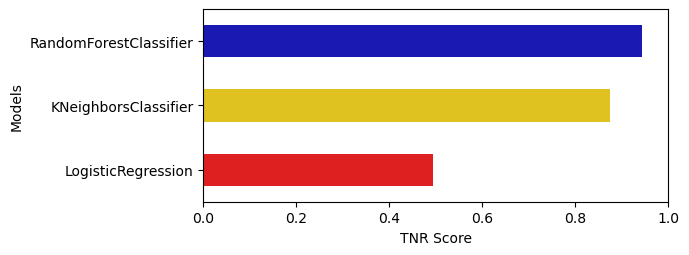

In [33]:
# Show TPR & TNR of models
r_palette = ["mediumblue", "gold", "red"]

plt.figure(figsize=(6,2.5))
sns.barplot(data=bin_all_results, x='Bin_TPR', y='Bin_Model', width=0.5, palette=r_palette)
plt.xlabel("TPR Score")
plt.ylabel("Models")
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

plt.figure(figsize=(6,2.5))
sns.barplot(data=bin_all_results, x='Bin_TNR', y='Bin_Model', width=0.5, palette=r_palette)
plt.xlabel("TNR Score")
plt.ylabel("Models")
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

## Multi-class Classification

In [34]:
# Split data into 70% training set and 30% test set
# X: features; y: target
multi_X_train, multi_X_test, multi_y_train, multi_y_test = train_test_split(X, multi_y,
                                                                            test_size=0.3, random_state=SEED)
                                
print('Shape of training set: ', multi_X_train.shape)
print('Shape of test set: ', multi_X_test.shape)

Shape of training set:  (316048, 12)
Shape of test set:  (135450, 12)



RandomForestClassifier Results:

Accuracy: 0.995

              precision    recall  f1-score   support

      Benign       0.90      0.97      0.93      3179
  BruteForce       0.90      0.35      0.50        26
        DDoS       1.00      1.00      1.00     98595
         DoS       1.00      1.00      1.00     23421
       Mirai       1.00      1.00      1.00      7725
       Recon       0.83      0.83      0.83      1039
    Spoofing       0.91      0.81      0.86      1394
   Web-Based       0.76      0.18      0.30        71

    accuracy                           1.00    135450
   macro avg       0.91      0.77      0.80    135450
weighted avg       1.00      1.00      0.99    135450

[[ 3074     0     0     0     0    57    47     1]
 [    5     9     0     0     0     6     6     0]
 [    0     0 98574    13     0     7     1     0]
 [    0     0     6 23414     0     0     1     0]
 [    0     0     3     1  7713     8     0     0]
 [  129     0     9     0     0   861    37

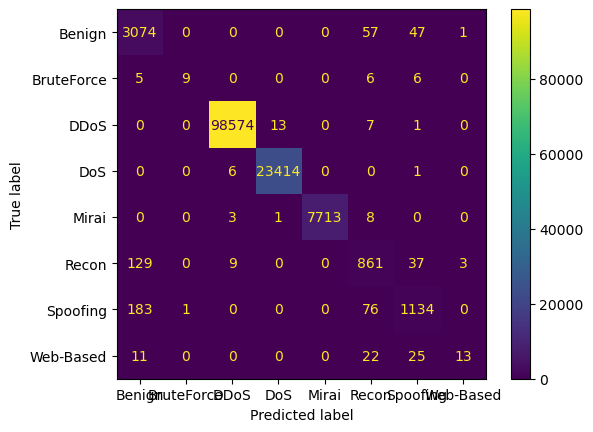


KNeighborsClassifier Results:

Accuracy: 0.991

              precision    recall  f1-score   support

      Benign       0.79      0.91      0.85      3179
  BruteForce       0.92      0.42      0.58        26
        DDoS       1.00      1.00      1.00     98595
         DoS       1.00      1.00      1.00     23421
       Mirai       1.00      1.00      1.00      7725
       Recon       0.81      0.75      0.78      1039
    Spoofing       0.76      0.58      0.66      1394
   Web-Based       0.97      0.42      0.59        71

    accuracy                           0.99    135450
   macro avg       0.91      0.76      0.81    135450
weighted avg       0.99      0.99      0.99    135450

[[ 2900     0     0     0     0    78   201     0]
 [    8    11     0     0     0     4     3     0]
 [    4     0 98536    21     9    24     1     0]
 [    2     0    20 23395     1     3     0     0]
 [    3     0    19     4  7699     0     0     0]
 [  205     0     7     0     0   783    43  

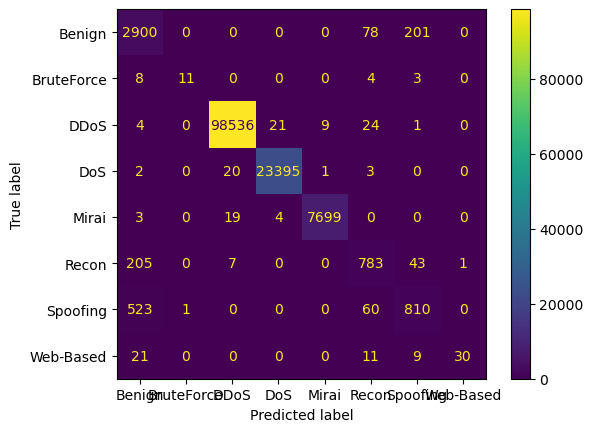


LogisticRegression Results:

Accuracy: 0.747

              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00      3179
  BruteForce       0.00      0.00      0.00        26
        DDoS       0.76      1.00      0.86     98595
         DoS       0.07      0.00      0.00     23421
       Mirai       0.60      0.29      0.39      7725
       Recon       0.00      0.00      0.00      1039
    Spoofing       0.26      0.52      0.34      1394
   Web-Based       0.00      0.00      0.00        71

    accuracy                           0.75    135450
   macro avg       0.21      0.22      0.20    135450
weighted avg       0.60      0.75      0.65    135450

[[    0     0   871     5   718     0  1585     0]
 [    0     0    14     0     0     0    12     0]
 [    5     0 98210     1   366     0    13     0]
 [    0     0 23384     1    29     0     7     0]
 [  105     0  5405     0  2212     0     3     0]
 [    3     0   542     5    59     0   430    

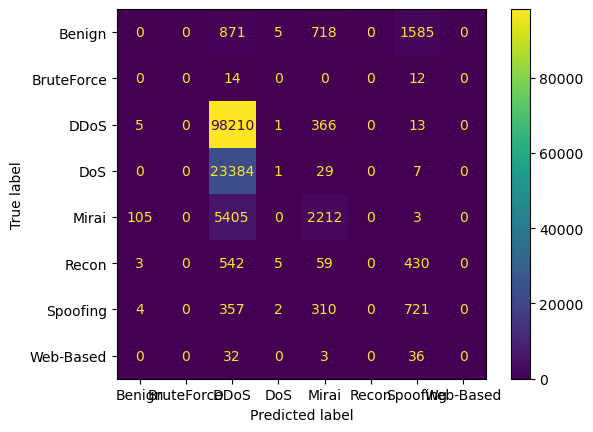

In [35]:
# Lists for evaluation metrics
multi_model_list = []
multi_accuracy_list = []

for model in models:
    model_name = model.__class__.__name__
    model.fit(multi_X_train, multi_y_train)
    model_predictions = model.predict(multi_X_test)

    cm = confusion_matrix(multi_y_test, model_predictions, labels=model.classes_)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                        display_labels=['Benign', 'BruteForce', 'DDoS', 'DoS', 'Mirai',
                                                        'Recon', 'Spoofing', 'Web-Based'])

    # Mapping of scorer name to scorer function
    accuracy = round(metrics.accuracy_score(multi_y_test, model_predictions), 3)

    # Append results to corresponding lists
    multi_model_list.append(model_name)
    multi_accuracy_list.append(accuracy)

    print(f"\n{model_name} Results:")
    print(f'\nAccuracy: {accuracy}\n')

    print(classification_report(multi_y_test, model_predictions, 
                                target_names=['Benign', 'BruteForce', 'DDoS', 'DoS', 'Mirai', 
                                              'Recon', 'Spoofing', 'Web-Based']))
    
    print(cm)
    cm_display.plot()
    plt.show()

    print("=" * 120)

### Accuracy

In [36]:
# Convert lists to a single DataFrame
accuracy_dict = {"Model": multi_model_list, "Accuracy": multi_accuracy_list}
accuracy_df = pd.DataFrame(accuracy_dict)

accuracy_df

,Model,Accuracy
0,RandomForestClassifier,0.995
1,KNeighborsClassifier,0.991
2,LogisticRegression,0.747


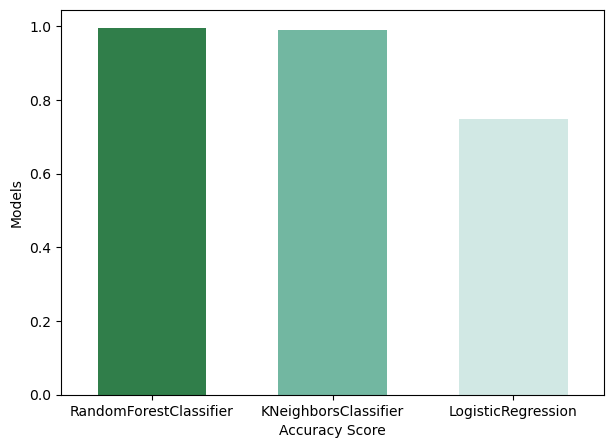

In [37]:
# Show accuracies
plt.figure(figsize=(7,5))
sns.barplot(data=accuracy_df, x='Model', y='Accuracy', palette='BuGn_r', width=0.6)

plt.xlabel("Accuracy Score")
plt.ylabel("Models")
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.show()

# The Optimal Model

In [38]:
# Instantiate the optimal model
rfc = RandomForestClassifier(random_state=SEED)

## DETECTION : Binary

In [39]:
# Fit 'rfc' to the binary training set
rfc.fit(bin_X_train, bin_y_train)

RandomForestClassifier(random_state=21)

In [40]:
# Save model using pickle
filename = 'iot_traffic_attack_detector.pkl'

# Write to file in binary format
pickle.dump(rfc, open(filename, 'wb'))

In [41]:
# Load your model
with open('iot_traffic_attack_detector.pkl', 'rb') as file:
    model = pickle.load(file)

# Compress the model
with gzip.open('compressed_iot_traffic_attack_detector.pkl.gz', 'wb') as zipfile:
    pickle.dump(model, zipfile)

## CLASSIFICATION : Multi-class

In [42]:
# Fit 'rfc' to the multi-class training set
rfc.fit(multi_X_train, multi_y_train)

RandomForestClassifier(random_state=21)

In [43]:
# Save model using pickle
filename = 'iot_traffic_attack_classifier.pkl'

# Write to file in binary format
pickle.dump(rfc, open(filename, 'wb'))

In [44]:
# Load your model
with open('iot_traffic_attack_classifier.pkl', 'rb') as file:
    model = pickle.load(file)

# Compress the model
with gzip.open('compressed_iot_traffic_attack_classifier.pkl.gz', 'wb') as zipfile:
    pickle.dump(model, zipfile)